In [1]:
'''Loss model for single photon displacement.  **Note** There are two different methods to perform
the photon catalysis.  One using a fictitious loss beamsplitter to simulate the imperfect detector
efficiency, while the other uses detector POVMs.  The methods are numerically equivalent, but the POVM
method is much more computationally efficient.'''

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex

In [3]:
xvec = np.arange(-40.,40.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
N_dim = 25 ##Dimenstion of the Hilbert space
#amp =0.707*(1+1j) ## Coherent state
#amp =  1.732*(1+1j)
amp = 1*(1+1j)
#amp=np.sqrt(3/2)*(1+1j)
a1 = destroy(N_dim) ##Lowering operator 
a2 = destroy(N_dim) ##Lowering operator 
a3 = destroy(N_dim) ##Lowering operator 
Fock_state = fock(N_dim, 1) ##single photon state
Fock_state_2 = fock(N_dim, 2) ##two photon state
Wigner_Fock_state = wigner(Fock_state,xvec,xvec)
'''Displacement Operator, takes a density matrix as input and outputs a density matrix displaced by alpha'''
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_single_photon_filter(a1, a2, k):
    theta_k = np.arctan(np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm() ##expm() is Matrix exponential of quantum object.
def BS_50_50(a1,a2):
    b = (np.pi/4)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm() ##expm() is Matrix exponential of quantum object.
def coherent_state_PDF(n, alpha): ##for later use when calculation probability distribution function
    mean_photon = abs(alpha)*abs(alpha)
    prob = math.exp(-mean_photon)*pow(mean_photon, n)/math.factorial(n)
    return prob, mean_photon
def fid_calc(psi_1, psi_2):
    fid = fidelity(psi_1, psi_2)
    return fid    
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
'''The fuction Fock_Filter takes an input state and filters out the |num> Fock state by applying the BS operator
to the initial state and a |1> state, followed by a projective measurement (single photon detection)
on the first output.  The normalized density matrix of the filtered state is then returned.'''
def Fock_Filter(in_state,num):
    Projector = tensor(Fock_state*Fock_state.dag(),qeye(N_dim));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_single_photon_filter(a1,a2,num)*Initial_state*BS_single_photon_filter(a1,a2,num).dag();
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
def Fock_Filter_prob(in_state,num):
    Projector = tensor(Fock_state*Fock_state.dag(),qeye(N_dim));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_single_photon_filter(a1,a2,num)*Initial_state*BS_single_photon_filter(a1,a2,num).dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
'''Now define a Fock Filter operation where instead of detecting a single photon and using a variable BS to filter out
n photons, detect n photons and use a 50:50 BS to filter out n photons!  Lets see if there is actually a difference'''
def Fock_Filter_50_50(in_state,num):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_50_50(a1,a2)*Initial_state*BS_50_50(a1,a2).dag();
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
def Fock_Filter_gen(in_state,refl,num,eta):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(Fock_state),ket2dm(fock(N_dim,0)));
    theta_loss = np.arcsin(np.sqrt(1-eta*eta));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag(),qeye(N_dim)) - tensor(a1.dag(),a2,qeye(N_dim)))).expm()
    BS_loss=(theta_loss*(tensor(a1,qeye(N_dim),a3.dag())-tensor(a1.dag(),qeye(N_dim),a3))).expm()
    
    Rho=BS1*Initial_state*BS1.dag();
    Rho2=BS_loss*Rho*BS_loss.dag();
    
    Rho_filtered = ((Rho2*Projector).ptrace(1))/((Rho2*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency',eta)
    return Rho_filtered
def Fock_Filter_50_50_loss(in_state,num,eta):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim),qeye(N_dim));
    Initial_state=tensor(ket2dm(Fock_state),in_state,ket2dm(fock(N_dim,0)));
    theta_loss = np.arcsin(np.sqrt(1-eta));
    
    BS1= ((np.pi/4)*(tensor(a1,a2.dag(),qeye(N_dim)) - tensor(a1.dag(),a2,qeye(N_dim)))).expm()
    BS_loss=(theta_loss*(tensor(a1,qeye(N_dim),a3.dag())-tensor(a1.dag(),qeye(N_dim),a3))).expm()
    
    Rho=BS1*Initial_state*BS1.dag();
    Rho2=BS_loss*Rho*BS_loss.dag();
    
    Rho_filtered = ((Rho2*Projector).ptrace(1))/((Rho2*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('I am filtering out the |',num,'> state, where my detector has efficiency',eta)
    return Rho_filtered
def Fock_Filter_50_50_prob(in_state,num):
    Projector = tensor(fock(N_dim, num)*fock(N_dim, num).dag(),qeye(N_dim));
    Initial_state=tensor(ket2dm(Fock_state),in_state);
    Rho=BS_50_50(a1,a2)*Initial_state*BS_50_50(a1,a2).dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    print('I am filtering out the |',num,'> state')
    return Rho_filtered
#def prob_dist(in_state,x_min,x_max):
    

In [ ]:
'''for an imperfect detector, the max fidelity happens when the target state is now a fock state displaced 
by beta = ((alpha)^2 - (n/eta))^(1/2) where eta is detector efficiency, alpha is initial coherent state 
amplitude, and n is the number of photons detected.  Also, it is now necessary that (alpha)^2/(r*eta)^2 = n  
**note, this is so far for a 50:50 BS, need to verify for general case**'''
eta=0.9
n=1
r_sq=1/2;

amp=np.sqrt(n/(r_sq*eta));
#amp=np.sqrt(4);
amp_cat=np.sqrt(5/4)*(1j)
cat=ket2dm(cat_minus(amp_cat));
#cat=ket2dm(Phase(np.pi/2)*cat_plus(amp_cat));
disp_fock=D(ket2dm(fock(N_dim,1)),np.sqrt((amp*amp-n/(eta))))
#dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(2-1))
W_dis=wigner(disp_fock,xvec,xvec);


filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq,n,eta)
#first_5050=Fock_Filter_50_50(ket2dm(coherent(N_dim,amp)),2)
W1=wigner(filtered,xvec,xvec);

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_dis, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_dis, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of displaced fock state')

fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W1, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of |1> filtered state')
fid = fidelity(disp_fock,filtered)
print('fidelity with displaced fock:',fid)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
bar0 = axes[0].bar(range(N_dim),filtered.diag())

lbl0 = axes[0].set_title("Filtered State")

lim0 = axes[0].set_xlim([-.5, 20])
bar1 = axes[1].bar(range(N_dim), cat.diag())

lbl1 = axes[1].set_title("Cat State")

lim1 = axes[1].set_xlim([-.5, 20])

bar2 = axes[2].bar(range(N_dim), ket2dm(coherent(N_dim,amp)).diag())

lbl2 = axes[2].set_title("Initial Coherent State")

lim2 = axes[2].set_xlim([-.5, 20])

plt.show()

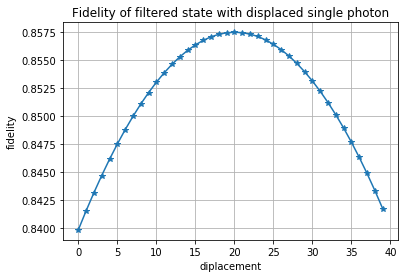

In [67]:
'''verification of the correct displacement of the maximum fidelity - the code can be
modified to zoom in on the peak.'''
F=np.zeros(40)
for i in range(40):
    dis_fock=D(ket2dm(fock(N_dim,1)),(0.005*i+0.9)*np.sqrt((amp*amp-n/(eta*eta))))
    F[i]=fidelity(dis_fock,filtered)
plt.plot(range(40),F,'-*')        
plt.grid()
plt.xlabel('diplacement')
plt.ylabel('fidelity')
#set_xlim([40, 60])
plt.title('Fidelity of filtered state with displaced single photon')
plt.show()

In [52]:
'''Define Four functions (G1-G4), each with a difference beamsplitter reflectivity, and then
produce a list of values of all of the maximum obtainable fidelities with the ideal displacement'''
G1=np.zeros(5)
G2=np.zeros(5)
G3=np.zeros(5)
G4=np.zeros(5)
n=2
r_sq1=1/2
r_sq2=2/3
r_sq3=3/4
r_sq4=7/8
alpha1=np.sqrt(n/r_sq1)
alpha2=np.sqrt(n/r_sq2)
alpha3=np.sqrt(n/r_sq3)
alpha4=np.sqrt(n/r_sq4)

#for i in range(5):
#    eta=1-0.05*i;
#    amp=alpha1/eta
#    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha1*alpha1-n)/eta);
#    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq1,n,eta)
#    G1[i]=fidelity(dis_fock,filtered)
for i in range(5):
    eta=1-0.05*i;
    amp=alpha2/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha2*alpha2-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq2,n,eta)
    G2[i]=fidelity(dis_fock,filtered)
for i in range(5):
    eta=1-0.05*i;
    amp=alpha3/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha3*alpha3-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq3,n,eta)
    G3[i]=fidelity(dis_fock,filtered)
for i in range(5):
    eta=1-0.05*i;
    amp=alpha4/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha4*alpha4-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq4,n,eta)
    G4[i]=fidelity(dis_fock,filtered)


BS has reflectivity 0.6666666666666666  and I am detecting the | 2 > state, where my detector has efficiency 1.0
BS has reflectivity 0.6666666666666666  and I am detecting the | 2 > state, where my detector has efficiency 0.95
BS has reflectivity 0.6666666666666666  and I am detecting the | 2 > state, where my detector has efficiency 0.9
BS has reflectivity 0.6666666666666666  and I am detecting the | 2 > state, where my detector has efficiency 0.85
BS has reflectivity 0.6666666666666666  and I am detecting the | 2 > state, where my detector has efficiency 0.8
BS has reflectivity 0.75  and I am detecting the | 2 > state, where my detector has efficiency 1.0
BS has reflectivity 0.75  and I am detecting the | 2 > state, where my detector has efficiency 0.95
BS has reflectivity 0.75  and I am detecting the | 2 > state, where my detector has efficiency 0.9
BS has reflectivity 0.75  and I am detecting the | 2 > state, where my detector has efficiency 0.85
BS has reflectivity 0.75  and I am 

In [78]:
'''Do the same thing, but now change the number of photons detected by the PNR detector.  Note that
this ONLY means that the inital coherent state must change, and that the displacement amplitude is different.
However, the achievable fidelity is INDEPENDENT of the number of photons detected, n, regardless of detector
efficiency.  This means that the displacement amplitude can by tuned by changing the initial coherent state 
amplitude and the number of photons detected.'''
F1=np.zeros(5)
F2=np.zeros(5)
F3=np.zeros(5)
F4=np.zeros(5)
n=1
r_sq1=1/2
r_sq2=2/3
r_sq3=3/4
r_sq4=7/8
alpha1=np.sqrt(n/r_sq1)
alpha2=np.sqrt(n/r_sq2)
alpha3=np.sqrt(n/r_sq3)
alpha4=np.sqrt(n/r_sq4)

for i in range(2):
    eta=0.75-0.05*i;
    amp=alpha1/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha1*alpha1-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq1,n,eta)
    F1[i]=fidelity(dis_fock,filtered)
for i in range(2):
    eta=0.75-0.05*i;
    amp=alpha2/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha2*alpha2-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq2,n,eta)
    F2[i]=fidelity(dis_fock,filtered)
for i in range(2):
    eta=0.75-0.05*i;
    amp=alpha3/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha3*alpha3-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq3,n,eta)
    F3[i]=fidelity(dis_fock,filtered)
for i in range(2):
    eta=0.75-0.05*i;
    amp=alpha4/eta
    dis_fock=D(ket2dm(fock(N_dim,1)),np.sqrt(alpha4*alpha4-n)/eta);
    filtered=Fock_Filter_gen(ket2dm(coherent(N_dim,amp)),r_sq4,n,eta)
    F4[i]=fidelity(dis_fock,filtered)


BS has reflectivity 0.5  and I am detecting the | 1 > state, where my detector has efficiency 0.75
BS has reflectivity 0.5  and I am detecting the | 1 > state, where my detector has efficiency 0.7
BS has reflectivity 0.6666666666666666  and I am detecting the | 1 > state, where my detector has efficiency 0.75
BS has reflectivity 0.6666666666666666  and I am detecting the | 1 > state, where my detector has efficiency 0.7
BS has reflectivity 0.75  and I am detecting the | 1 > state, where my detector has efficiency 0.75
BS has reflectivity 0.75  and I am detecting the | 1 > state, where my detector has efficiency 0.7
BS has reflectivity 0.875  and I am detecting the | 1 > state, where my detector has efficiency 0.75
BS has reflectivity 0.875  and I am detecting the | 1 > state, where my detector has efficiency 0.7


In [83]:
'''Recovered values from before so the code does not have to be re-run'''
F1=[1.00000027, 0.95454614, 0.91669255, 0.88473303, 0.8574691, 0.83407083, 0.81391257]
F2=[1.00000003, 0.97648149, 0.95563692, 0.9370995 , 0.92057423, 0.90582225, 0.89265035]
F3=[1.00000002, 0.98413568, 0.96976229, 0.95672975, 0.94491118, 0.93419887, 0.92450175]
F4=[1.00000001, 0.99310764, 0.98669877, 0.9807491 , 0.97523688, 0.97014253, 0.96544848]

G2

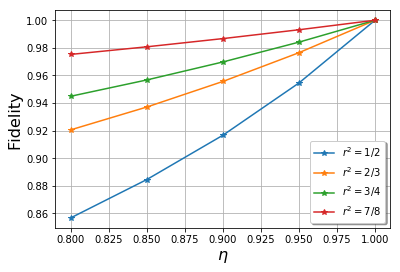

In [58]:
'''n=2 case plot'''
array=[1,0.95,0.9,0.85,0.8]
plt.plot(array,G1,'-*',array,G2,'-*',array,G3,'-*',array,G4,'-*')        
plt.grid()
plt.legend((r'$r^2=1/2$', r'$r^2=2/3$',r'$r^2=3/4$',r'$r^2=7/8$'),
           loc='lower right', shadow=True)
plt.xlabel(r'$\eta$',fontsize=16)
plt.ylabel('Fidelity',fontsize=16)
#set_xlim([40, 60])
#plt.title('Fidelity of filtered state with displaced single photon', fontsize=16)
plt.show()

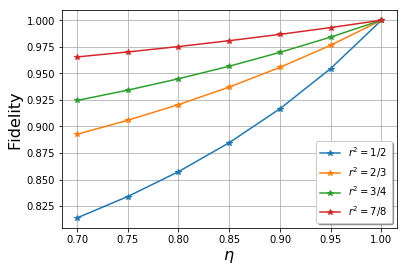

In [84]:
'''n=1 case plots'''
array=[1,0.95,0.9,0.85,0.8,0.75,0.7]
plt.plot(array,F1,'-*',array,F2,'-*',array,F3,'-*',array,F4,'-*')        
plt.grid()
plt.legend((r'$r^2=1/2$', r'$r^2=2/3$',r'$r^2=3/4$',r'$r^2=7/8$'),
           loc='lower right', shadow=True)
plt.xlabel(r'$\eta$',fontsize=16)
plt.ylabel('Fidelity',fontsize=16)
#set_xlim([40, 60])
#plt.title('Fidelity of filtered state with displaced single photon', fontsize=16)
plt.show()

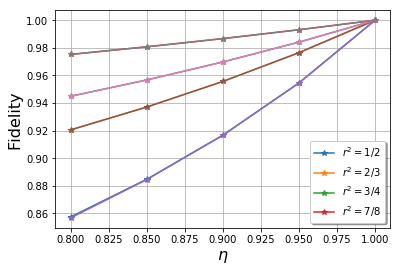

In [74]:
'''changing n doesn't change fidelities! Only r and eta matter'''
array=[1,0.95,0.9,0.85,0.8]
plt.plot(array,F1,'-*',array,F2,'-*',array,F3,'-*',array,F4,'-*',array,G1,'-*',array,G2,'-*',array,G3,'-*',array,G4,'-*')        
plt.grid()
plt.legend((r'$r^2=1/2$', r'$r^2=2/3$',r'$r^2=3/4$',r'$r^2=7/8$'),
           loc='lower right', shadow=True)
plt.xlabel(r'$\eta$',fontsize=16)
plt.ylabel('Fidelity',fontsize=16)
#set_xlim([40, 60])
#plt.title('Fidelity of filtered state with displaced single photon', fontsize=16)
plt.show()